# Clustering

In [1]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "8"

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import torch
print(torch.cuda.is_available())  # should return True
from umap import UMAP
from joblib import Parallel, delayed
import numpy as np

True


In [2]:
movies = pd.read_csv("../data/csv/movies.csv")
ratings = pd.read_csv("../data/csv/ratings.csv")

In [3]:
movies_ratings = ratings.merge(movies[['movieId', 'title', 'genres']], on='movieId', how='left')

print(movies_ratings.shape)
movies_ratings.head()

(25000095, 6)


,userId,movieId,rating,timestamp,title,genres
0,1,296,5.0,1147880044,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1,1,306,3.5,1147868817,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama
2,1,307,5.0,1147868828,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
3,1,665,5.0,1147878820,Underground (1995),Comedy|Drama|War
4,1,899,3.5,1147868510,Singin' in the Rain (1952),Comedy|Musical|Romance


In [4]:
# Reduce to top 5k users and top 1k most rated movies
top_movies = movies_ratings['movieId'].value_counts().head(10000).index
top_users = movies_ratings['userId'].value_counts().head(10000).index
filtered = movies_ratings[movies_ratings['movieId'].isin(top_movies) & movies_ratings['userId'].isin(top_users)]

pivot_df = filtered.pivot(index='userId', columns='movieId', values='rating')
pivot_df_centered = pivot_df.sub(pivot_df.mean(axis=1), axis=0).fillna(0)

## UMAP x KMeans

In [5]:
umap_model = UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
embedding = umap_model.fit_transform(pivot_df_centered.values)

/run/media/hakiim/Stuff/Uni/Sem2/SEP/uas-soe-python-ss-2025/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/run/media/hakiim/Stuff/Uni/Sem2/SEP/uas-soe-python-ss-2025/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [6]:
# KMeans clustering
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=20)
labels = clusterer.fit_predict(embedding)
hdbscan_score = silhouette_score(embedding, labels)

kmeans = KMeans(n_clusters=10, random_state=42)
kmeans_labels = kmeans.fit_predict(embedding)
kmeans_score = silhouette_score(embedding, kmeans_labels)

# DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(embedding)

core_mask = dbscan_labels != -1
if core_mask.sum() > 1:
    dbscan_score = silhouette_score(embedding[core_mask], dbscan_labels[core_mask])
else:
    dbscan_score = -1  # Not enough core points

print(f"HDBScan Silhouette Score: {hdbscan_score:.4f}")
print(f"KMeans Silhouette Score: {kmeans_score:.4f}")
print(f"DBSCAN Silhouette Score: {dbscan_score:.4f}")


/run/media/hakiim/Stuff/Uni/Sem2/SEP/uas-soe-python-ss-2025/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/run/media/hakiim/Stuff/Uni/Sem2/SEP/uas-soe-python-ss-2025/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBScan Silhouette Score: -0.3105
KMeans Silhouette Score: 0.3713
DBSCAN Silhouette Score: 0.2735


In [7]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50)
svd_embedding = svd.fit_transform(pivot_df_centered)

kmeans = KMeans(n_clusters=6)
labels = kmeans.fit_predict(svd_embedding)
score = silhouette_score(svd_embedding, labels)
score

0.05126247776503353

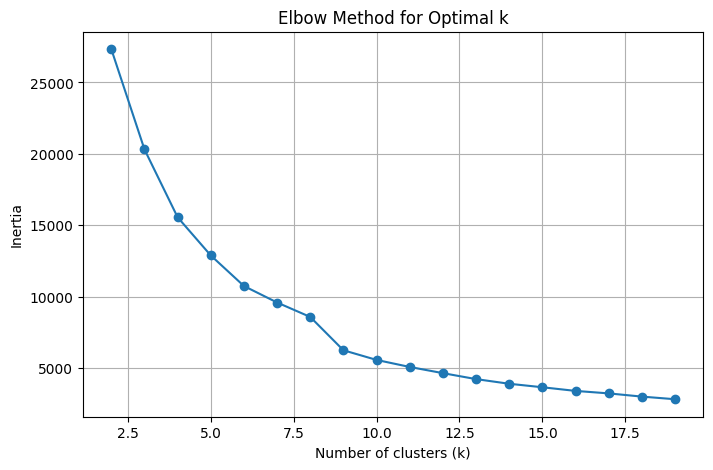

In [8]:
# search for the optimal k
inertias = []
K = range(2, 20)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(embedding)
    inertias.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

In [9]:
kmeans = KMeans(n_clusters=9, random_state=42)
kmeans_labels = kmeans.fit_predict(embedding)
kmeans_score = silhouette_score(embedding, kmeans_labels)

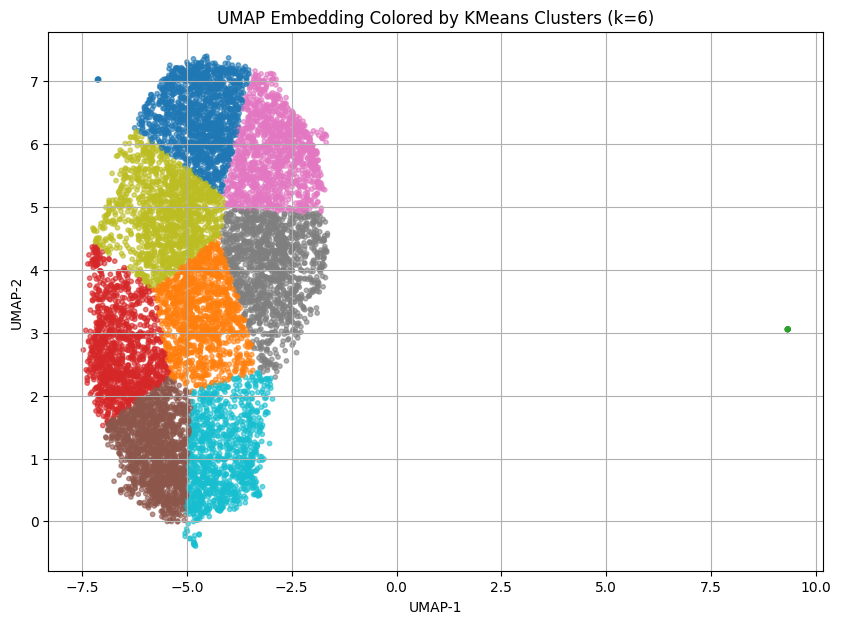

In [10]:
plt.figure(figsize=(10, 7))
plt.scatter(embedding[:, 0], embedding[:, 1], c=kmeans_labels, cmap='tab10', s=10, alpha=0.6)
plt.title("UMAP Embedding Colored by KMeans Clusters (k=6)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.show()

In [11]:
# Match cluster labels to user IDs
cluster_df = pd.DataFrame({
    'userId': pivot_df.index.tolist(),
    'cluster': kmeans_labels
})

In [12]:
print(len(pivot_df_centered.index), len(kmeans_labels))


10000 10000


In [13]:
from lenskit.data import from_interactions_df

# Only use users/items that are part of clustering
movies_ratings_filtered = filtered[
    (filtered['userId'].isin(pivot_df_centered.index)) &
    (filtered['movieId'].isin(pivot_df_centered.columns))
]
movies_ratings_clustered = movies_ratings_filtered.merge(cluster_df, on='userId', how='left')
movies_ratings_clustered.head()

,userId,movieId,rating,timestamp,title,genres,cluster
0,3,1,4.0,1439472215,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4
1,3,29,4.5,1484754967,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi,4
2,3,32,4.5,1439474635,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,4
3,3,50,5.0,1439474391,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,4
4,3,111,4.0,1484753849,Taxi Driver (1976),Crime|Drama|Thriller,4


In [14]:
def get_cluster_neighbors(user_id, cluster_df, user_id_map, reverse_user_id_map, annoy_index, k=30):
    if user_id not in user_id_map:
        return []

    cluster = cluster_df.loc[cluster_df['userId'] == user_id, 'cluster'].values[0]
    same_cluster_user_ids = set(cluster_df[cluster_df['cluster'] == cluster]['userId'])

    user_idx = user_id_map[user_id]
    raw_neighbors = annoy_index.get_nns_by_item(user_idx, k+1)  # include self

    neighbors = [reverse_user_id_map[i] for i in raw_neighbors if reverse_user_id_map[i] != user_id]
    cluster_neighbors = [uid for uid in neighbors if uid in same_cluster_user_ids]

    return cluster_neighbors

In [15]:
# Build LensKit dataset
lk_dataset = from_interactions_df(
    movies_ratings_clustered,
    user_col='userId',
    item_col='movieId',
    rating_col='rating',
)

# Optional: get a dense Pandas matrix (slow for large data)
pd_lk_dataset = lk_dataset.interaction_matrix(format='pandas')
pd_lk_dataset


,user_num,item_num,rating,timestamp,title,genres,cluster
0,0,0,4.0,1439472215,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4
1,0,28,4.5,1484754967,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi,4
2,0,31,4.5,1439474635,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,4
3,0,47,5.0,1439474391,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,4
4,0,103,4.0,1484753849,Taxi Driver (1976),Crime|Drama|Thriller,4
...,...,...,...,...,...,...,...
8649911,9999,3839,2.0,1000947348,3 Ninjas (1992),Action|Children|Comedy,5
8649912,9999,3873,1.0,1000946127,Phantom of the Paradise (1974),Comedy|Fantasy|Horror|Musical|Thriller,5
8649913,9999,3917,5.0,1001884147,Dirty Harry (1971),Action|Crime|Thriller,5
8649914,9999,3918,5.0,1001886067,Fiddler on the Roof (1971),Drama|Musical,5


In [16]:
# split into test and train sets
from lenskit.splitting import sample_users, SampleFrac

# DOCS: https://lkpy.lenskit.org/stable/api/lenskit.splitting.sample_users
split = sample_users(lk_dataset, rng=42, method=SampleFrac(0.2), size=1000)
"""
Splits the dataset based on users interactions.
The `method=SampleFrac(0.2),` means that for each user, 20% of their interactions will be used for testing, and the rest will be used for training.
"""

print(f"Train size: {split.train.interaction_count}, Test size: {len(split.test)}")

Train size: 8477827, Test size: 1000


In [17]:
from lenskit.pipeline import RecPipelineBuilder
from lenskit.knn import ItemKNNScorer
from lenskit.basic import UnratedTrainingItemsCandidateSelector

cluster_pipelines = {}

for cluster_id in cluster_df['cluster'].unique():
    user_ids_in_cluster = cluster_df[cluster_df['cluster'] == cluster_id]['userId']
    cluster_data = movies_ratings_filtered[movies_ratings_filtered['userId'].isin(user_ids_in_cluster)]

    if cluster_data.empty:
        continue  # Skip clusters with no data

    cluster_lk_dataset = from_interactions_df(
        cluster_data,
        user_col='userId',
        item_col='movieId',
        rating_col='rating'
    )

    # Step 1: Create a new pipeline builder for each cluster
    builder = RecPipelineBuilder()

    # Step 2: Configure the builder
    builder.scorer(ItemKNNScorer(k=20))
    builder.candidate_selector(UnratedTrainingItemsCandidateSelector())
    builder.ranker(n=25)

    # Step 3: Build and train pipeline
    cluster_pipe = builder.build(f"ItemKNN for Cluster {cluster_id}")
    cluster_pipe.train(cluster_lk_dataset)

    # Step 4: Store the trained pipeline
    cluster_pipelines[cluster_id] = cluster_pipe

In [18]:
cluster_sizes = cluster_df['cluster'].value_counts()
print(cluster_sizes)


cluster
4    1412
0    1393
7    1337
6    1292
5    1236
1    1158
3    1146
8    1010
2      16
Name: count, dtype: int64


In [19]:
MIN_CLUSTER_SIZE = 50
valid_clusters = cluster_df['cluster'].value_counts()
valid_clusters = valid_clusters[valid_clusters > MIN_CLUSTER_SIZE].index
cluster_df = cluster_df[cluster_df['cluster'].isin(valid_clusters)]

# CV

In [ ]:
from collections import defaultdict
from lenskit.splitting import crossfold_users, SampleFrac
from lenskit.pipeline import RecPipelineBuilder
from lenskit.knn import ItemKNNScorer
from lenskit.basic import UnratedTrainingItemsCandidateSelector
from lenskit.batch import recommend as batch_recommend
from tqdm.notebook import tqdm
from lenskit.data import from_interactions_df, MutableItemListCollection, UserIDKey

# your hyperparameter grid
param_grid = [1e-6, 0.005, 0.01, 0.05, 0.07, 0.1, 0.5]

cluster_ids = cluster_df['cluster'].unique()
cv_results = defaultdict(lambda: defaultdict(list))

for cid in tqdm(cluster_ids, desc="Clusters"):
    # select users in this cluster
    users = cluster_df.loc[cluster_df.cluster == cid, 'userId']
    if len(users) < 50:
        continue

    # filter ratings to just those users
    data = movies_ratings_filtered[movies_ratings_filtered.userId.isin(users)]
    if data.empty:
        continue

    # convert to LensKit dataset once
    ds = from_interactions_df(data,
                              user_col='userId',
                              item_col='movieId',
                              rating_col='rating')
    # make all 5 folds
    folds = list(crossfold_users(ds,
                                 partitions=5,
                                 method=SampleFrac(0.2),
                                 rng=42))
    builder_base = RecPipelineBuilder()
    builder_base.candidate_selector(UnratedTrainingItemsCandidateSelector())
    builder_base.ranker(n=10)

    for p in param_grid:
        all_test = MutableItemListCollection(UserIDKey)
        all_rec  = MutableItemListCollection(UserIDKey)

        builder_base.scorer(ItemKNNScorer(min_sim=p))
        pipe = builder_base.build()

        total_recs = 0
        total_users = 0

        for split in folds:
            if split.train.interaction_count == 0 or len(split.test) == 0:
                continue

            model = pipe.clone()
            model.train(split.train)

            uids = [key.user_id for key in split.test.keys()]
            recs = batch_recommend(model, uids, n=25)

            all_test.add_from(split.test)
            all_rec.add_from(recs)

        df_rec = all_rec.to_df()
        avg_rec = len(df_rec) / len(uids) if uids else 0.0

        cv_results[cid][p].append({
            'avg_rec': avg_rec,
            'test': all_test,
            'rec': all_rec
        })

# cv_results is now a dict-of-dicts: {cluster: {reg: avg_rec}}


Clusters:   0%|          | 0/8 [00:00<?, ?it/s]

In [45]:
df_rec.head()

,user_id,item_id,score,rank
0,134255,1,5.071466,1
1,134255,7438,4.913096,2
2,134255,588,4.500012,3
3,134255,5117,4.250000,4
4,134255,1029,4.090785,5


In [48]:
from lenskit.data import ItemListCollection, UserIDKey
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import mean_squared_error
from lenskit.metrics import RunAnalysis, Precision, Recall, Hit, NDCG, RMSE
import pandas as pd

analysis = RunAnalysis()
analysis.add_metric(Precision())
analysis.add_metric(Recall())
analysis.add_metric(NDCG())
analysis.add_metric(Hit())
analysis.add_metric(RMSE())

def measure_performance(test: ItemListCollection, rec: ItemListCollection[UserIDKey]):
    df_rec = rec.to_df()
    df_test = test.to_df()

    test_users = df_test['user_id'].unique()
    num_test_users = len(test_users)
    num_recs = len(df_rec)

    avg_rec = num_recs / num_test_users if num_test_users > 0 else 0.0

    # Edge case: no predictions or test data
    if df_rec.empty or df_test.empty:
        return pd.DataFrame([{
            'Precision': 0.0, 'Recall': 0.0, 'NDCG': 0.0, 'Hit': 0.0,
            'MSE': None, 'RMSE': None, 'AvgRec': avg_rec
        }])

    hits = (
        df_test[['user_id', 'item_id', 'rating']]
        .merge(df_rec[['user_id', 'item_id', 'score']],
               on=['user_id', 'item_id'],
               how='inner')
    )

    if hits.empty:
        return pd.DataFrame([{
            'Precision': 0.0, 'Recall': 0.0, 'NDCG': 0.0, 'Hit': 0.0,
            'MSE': None, 'RMSE': None, 'AvgRec': avg_rec
        }])

    mse = mean_squared_error(hits['rating'], hits['score'])
    rmse = mse ** 0.5

    try:
        results = analysis.measure(rec, test)
        metrics = results.list_metrics().mean().to_dict()

        # Ensure all keys are present
        return pd.DataFrame([{
            'Precision': metrics.get('Precision', 0.0),
            'Recall': metrics.get('Recall', 0.0),
            'NDCG': metrics.get('NDCG', 0.0),
            'Hit': metrics.get('Hit', 0.0),
            'RMSE': metrics.get('RMSE', rmse),
            'MSE': mse,
            'AvgRec': avg_rec
        }])

    except Exception as e:
        print(f"[WARNING] Metric calculation failed: {e}")
        return pd.DataFrame([{
            'Precision': 0.0, 'Recall': 0.0, 'NDCG': 0.0, 'Hit': 0.0,
            'MSE': mse, 'RMSE': rmse, 'AvgRec': avg_rec
        }])


In [49]:
def normalize_metrics(df, keys):
    for key in keys:
        df[key + "_norm"] = minmax_scale(df[key])
    return df

for cluster_id, param_results in cv_results.items():
    print(f"\n=== Cluster {cluster_id} ===")

    # Collect all performance rows for normalization
    all_rows = []
    for param, results_list in param_results.items():
        res = results_list[0]
        perf_df = measure_performance(res['test'], res['rec'])
        perf_df['min_sim'] = param  # track param
        all_rows.append(perf_df)

    # Combine and normalize
    combined_df = pd.concat(all_rows, ignore_index=True)
    metric_keys = ['Precision', 'Recall', 'Hit']
    combined_df = normalize_metrics(combined_df, metric_keys)

    # Compute composite score using normalized values
    combined_df['Composite'] = (
        0.25 * combined_df['Hit_norm'] +
        0.25 * combined_df['Precision_norm'] +
        0.2 * combined_df['Recall_norm']
    )

    # Print results
    for _, row in combined_df.iterrows():
        print(f"--- min_sim = {row['min_sim']} ---")
        print(row[['Precision', 'Recall', 'Hit', 'Composite', 'AvgRec']])


| **Metric**        | **In the context of movie predictions**                                                                                                                                 |
| ----------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Precision\@k**  | Of the top-k movies recommended to a user, **how many were actually watched** by the user in the test set? Measures how many recommendations were **correct**.          |
| **Recall\@k**     | Of the movies a user actually watched in the test set, **how many were found in the top-k recommendations**? Measures how well the system **recovers relevant movies**. |
| **F1\@k**         | The **harmonic mean of precision and recall** — balances how accurate and how complete the recommendations are. Useful when both are important.                         |
| **Hit Rate\@k**   | Did the top-k recommendation list for a user **include at least one movie** they actually watched in the test set? A simple "got one right or not" measure.             |
| **NDCG\@k**       | Do the movies a user actually watched in the test set appear **early in the recommendation list**? Rewards correct predictions near the top of the list more heavily.   |
| **Coverage**      | Out of all movies in your database, **how many different ones were ever recommended** to users? Measures how much of the movie catalog your system actually utilizes.   |
| **User coverage** | Out of all users in the test set, **how many received at least one recommendation** (i.e., didn’t fail silently)? Helps identify coverage holes like cold-start users.  |


# Final Model

In [134]:
import pickle
from lenskit.knn import ItemKNNScorer
from lenskit.pipeline import RecPipelineBuilder
from lenskit.basic import UnratedTrainingItemsCandidateSelector
from lenskit.data import from_interactions_df

best_min_sim = {
    0: 0.5,
    1: 0.01,
    2: 0.5,
    3: 0.07,
    4: 0.1,
    5: 0.5,
}

final_cluster_pipelines = {}

for cluster_id in cluster_df['cluster'].unique():
    user_ids_in_cluster = cluster_df[cluster_df['cluster'] == cluster_id]['userId']
    cluster_data = movies_ratings_filtered[movies_ratings_filtered['userId'].isin(user_ids_in_cluster)]

    if cluster_data.empty:
        continue

    cluster_lk_dataset = from_interactions_df(
        cluster_data,
        user_col='userId',
        item_col='movieId',
        rating_col='rating'
    )
    min_sim_value = best_min_sim.get(cluster_id, 0.1)
    builder = RecPipelineBuilder()
    builder.scorer(ItemKNNScorer(min_sim=min_sim_value))
    builder.candidate_selector(UnratedTrainingItemsCandidateSelector())
    builder.ranker(n=25)

    pipe = builder.build(f"Final KNN - Cluster {cluster_id}")
    pipe.train(cluster_lk_dataset)

    # Store everything in a single dictionary entry
    final_cluster_pipelines[cluster_id] = {
        "model": pipe,
        "user_ids": list(set(cluster_data['userId'])),
        "item_ids": list(set(cluster_data['movieId']))
    }


# Export model

In [135]:
export_name = "all_cluster_models.pkl"

with open(export_name, "wb") as f:
    pickle.dump(final_cluster_pipelines, f)


# Import Model

In [136]:
with open("all_cluster_models.pkl", "rb") as f:
    loaded_cluster_models = pickle.load(f)

# Example usage
cluster_id = 3
model = loaded_cluster_models[cluster_id]["model"]
user_ids = loaded_cluster_models[cluster_id]["user_ids"]
item_ids = loaded_cluster_models[cluster_id]["item_ids"]

# Recommend

In [137]:
print(cluster_df)

      userId  cluster
0         12        0
1         72        1
2        187        5
3        321        3
4        426        3
...      ...      ...
4995  162445        1
4996  162484        0
4997  162495        5
4998  162508        4
4999  162516        5

[5000 rows x 2 columns]


In [141]:
from lenskit.data import RecQuery, ItemList
from lenskit import recommend

# Load the exported cluster models
with open("all_cluster_models.pkl", "rb") as f:
    loaded_cluster_models = pickle.load(f)

user_id = 162508  # must be in your dataset
user_hist_df = movies_ratings_filtered[movies_ratings_filtered['userId'] == user_id].copy()
user_hist_df.rename(columns={'userId': 'user_id', 'movieId': 'item_id'}, inplace=True)

# Determine user's cluster
cluster_id = cluster_df[cluster_df['userId'] == user_id]['cluster'].values[0]

# Get the trained model and its item list for this cluster
cluster_model_bundle = loaded_cluster_models[cluster_id]
model = cluster_model_bundle["model"]
trained_item_ids = set(cluster_model_bundle["item_ids"])

# Filter user history to only items the model was trained on
user_hist_df = user_hist_df[user_hist_df['item_id'].isin(trained_item_ids)]

# Build query
hist_items = ItemList.from_df(user_hist_df, keep_user=False)
query = RecQuery(user_id=user_id, user_items=hist_items)

# Get recommendations
rec = recommend(model, query, n=10)
rec_df = rec.to_df()

# Merge with metadata
output = rec_df.merge(movies, left_on='item_id', right_on='movieId', how='left')[['item_id', 'title', 'score']]
print(output)


   item_id                                              title     score
0      745             Wallace & Gromit: A Close Shave (1995)  4.844439
1      527                            Schindler's List (1993)  4.816108
2    78499                                 Toy Story 3 (2010)  4.711032
3     2762                            Sixth Sense, The (1999)  4.699685
4    68358                                   Star Trek (2009)  4.698847
5    76093                    How to Train Your Dragon (2010)  4.689455
6     7153  Lord of the Rings: The Return of the King, The...  4.679534
7    54286                       Bourne Ultimatum, The (2007)  4.676349
8      720  Wallace & Gromit: The Best of Aardman Animatio...  4.674404
9    81834  Harry Potter and the Deathly Hallows: Part 1 (...  4.572868


In [143]:
print(user_hist_df.sort_values('rating', ascending=False))


          user_id  item_id  rating   timestamp  \
24990859   162508    81847     5.0  1365194104   
24990696   162508    60069     5.0  1365194340   
24990693   162508    59784     5.0  1365194187   
24990688   162508    59369     5.0  1365194348   
24989642   162508      318     5.0  1365193664   
...           ...      ...     ...         ...   
24990458   162508    33493     0.5  1365193778   
24989659   162508      515     0.5  1365193636   
24989650   162508      441     0.5  1365193619   
24989669   162508      608     0.5  1365193705   
24989643   162508      337     0.5  1365193641   

                                                      title  \
24990859                                     Tangled (2010)   
24990696                                      WALL·E (2008)   
24990693                               Kung Fu Panda (2008)   
24990688                                       Taken (2008)   
24989642                   Shawshank Redemption, The (1994)   
...                  